### Colorization AutoEncoder PyTorch Demo using CIFAR10

In this demo, we build a simple colorization autoencoder using PyTorch.

In [6]:
! pip install lightning torch torchvision --upgrade

In [7]:
import torch
import torchvision

import time

from torch import nn
from einops import rearrange, reduce
from argparse import ArgumentParser
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

#### CNN Encoder using PyTorch

We use 3 CNN layers to encode the grayscale input image. We use stride of 2 to reduce the feature map size. The last MLP layer resizes the flattened feature map to the target latent vector size. We use more filters and a much bigger latent vector size of 256 to encode more information.

In [8]:
class Encoder(nn.Module):
    def __init__(self, n_features=1, kernel_size=3, n_filters=64, feature_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(n_features, n_filters, kernel_size=kernel_size, stride=2)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, kernel_size=kernel_size, stride=2)
        self.conv3 = nn.Conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size, stride=2)
        self.fc1 = nn.Linear(2304, feature_dim)
        
    def forward(self, x):
        y = nn.ReLU()(self.conv1(x))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        return y


# use this to get the correct input shape for  fc1. 
encoder = Encoder(n_features=1)
x = torch.Tensor(1, 1, 32, 32)
h = encoder(x)
print("h.shape:", h.shape)

h.shape: torch.Size([1, 256])


### CNN Decoder using PyTorch

A decoder is used to reconstruct the input image. The decoder is trained to reconstruct the input data from the latent space. The architecture is similar to the encoder but inverted. A latent vector is resized using an MLP layer so that it is suitable for a convolutional layer. We use strided tranposed convolutional layers to upsample the feature map until the desired image size is reached. The target image is the colorized version of the input image.

In [9]:
class Decoder(nn.Module):
    def __init__(self, kernel_size=3, n_filters=256, feature_dim=256, output_size=32, output_channels=3):
        super().__init__()
        self.init_size = output_size // 2**2 
        self.fc1 = nn.Linear(feature_dim, self.init_size**2 * n_filters)
        # output size of conv2dtranspose is (h-1)*2 + 1 + (kernel_size - 1)
        self.conv1 = nn.ConvTranspose2d(n_filters, n_filters//2, kernel_size=kernel_size, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(n_filters//2, n_filters//4, kernel_size=kernel_size, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(n_filters//4, n_filters//4, kernel_size=kernel_size, padding=1)
        self.conv4 = nn.ConvTranspose2d(n_filters//4, output_channels, kernel_size=kernel_size+1)

    def forward(self, x):
        B, _ = x.shape
        y = self.fc1(x)
        y = y.reshape(B, -1, self.init_size, self.init_size)
        y = nn.ReLU()(self.conv1(y))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = nn.Sigmoid()(self.conv4(y))

        return y


#### PyTorch Lightning Colorization AutoEncoder

In the colorization autoencoder, the encoder extracts features from the input image and the decoder reconstructs the input image from the latent space. The decoder adds color. The decoder's last layer has 3 output channels corresponding to RGB.

We `gray_collate_fn` to generate gray images from RGB images. 

In [21]:
from typing import Any, Optional
import lightning as L

def gray_collate_fn(batch):
    x, _ = zip(*batch)
    x = torch.stack(x, dim=0)
    xn = torch.mean(x, dim=1, keepdim=True)
    return xn, x

class LColorizeCIFAR10Model(L.LightningModule):
    def __init__(self, feature_dim=256, lr=0.001, batch_size=64,
                 num_workers=4, max_epochs=30, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(feature_dim=feature_dim)
        self.decoder = Decoder(feature_dim=feature_dim)
        self.loss = nn.MSELoss()
        self.train_losses = []
        self.test_losses = []

    def forward(self, x):
        h = self.encoder(x)
        x_tilde = self.decoder(h)
        return x_tilde

    def on_train_epoch_start(self) -> None:
        self.train_losses.clear()
    
    # this is called during fit()
    def training_step(self, batch, batch_idx):
        x_in, x = batch
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        self.train_losses.append(loss)
        return {"loss": loss}

    def on_train_epoch_end(self) -> None:
        avg_loss = torch.stack([x for x in self.train_losses]).mean()
        self.log("train_loss", avg_loss, on_epoch=True, prog_bar=True)

    def on_test_epoch_start(self) -> None:
        self.test_losses.clear()

    # this is called at the end of an epoch
    def test_step(self, batch, batch_idx):
        x_in, x = batch
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        self.test_losses.append(loss)
        return {"test_loss" : loss,}

    # this is called at the end of all epochs
    def on_test_epoch_end(self):
        avg_loss = torch.stack([x for x in self.test_losses]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)

    def on_validation_epoch_start(self) -> None:
        return self.on_test_epoch_start()

    # validation is the same as test
    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def on_validation_epoch_end(self):
        return self.on_test_epoch_end()

    # we use Adam optimizer
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        # this decays the learning rate to 0 after max_epochs using cosine annealing
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler], 
    
    # this is called after model instatiation to initiliaze the datasets and dataloaders
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    # build train and test dataloaders using MNIST dataset
    # we use simple ToTensor transform
    def train_dataloader(self):        
        return torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(
                "~/data", train=True, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=gray_collate_fn
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(
                "~/data", train=False, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=gray_collate_fn
        )

    def val_dataloader(self):
        return self.test_dataloader()

In [22]:
model = LColorizeCIFAR10Model()

trainer = L.Trainer(max_epochs=30, devices=1, accelerator="gpu")
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 959 K 
1 | decoder | Decoder | 4.6 M 
2 | loss    | MSELoss | 0     
------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.317    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Files already downloaded and verified


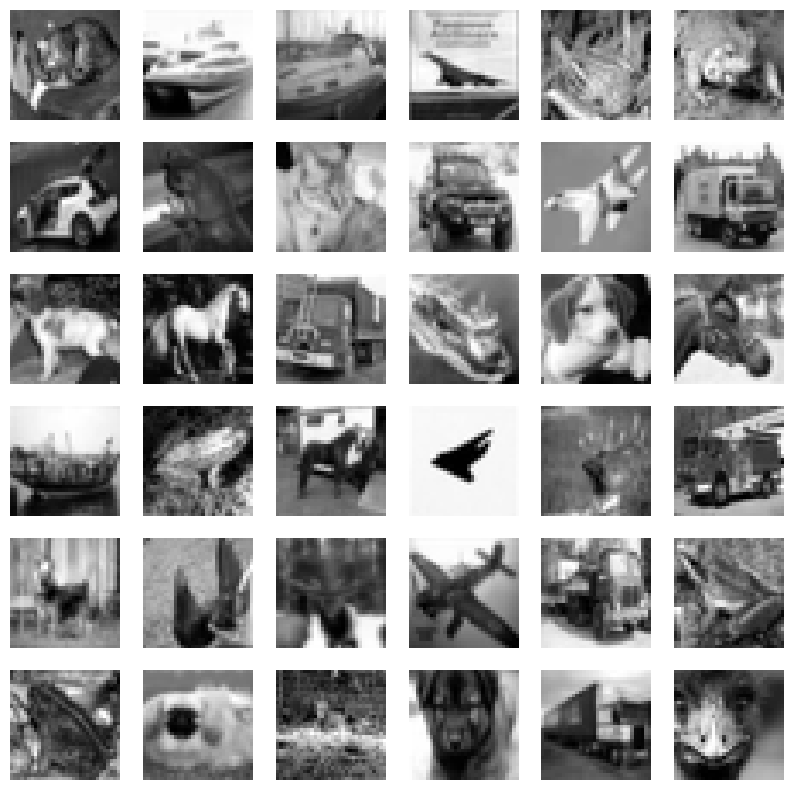

In [24]:
import matplotlib.pyplot as plt

# get 36 images from test dataloader
test_dl = model.test_dataloader()
test_batch = next(iter(test_dl))
x_in, x = test_batch
x_in = x_in[:36]

# visualize the grayscale images
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
for i in range(6):
    for j in range(6):
        idx = i*6 + j
        axs[i, j].imshow(x_in[idx].squeeze(), cmap='gray')
        axs[i, j].axis('off')
plt.show()

# pass through the model
with torch.no_grad():
    x_tilde = model(x_in)




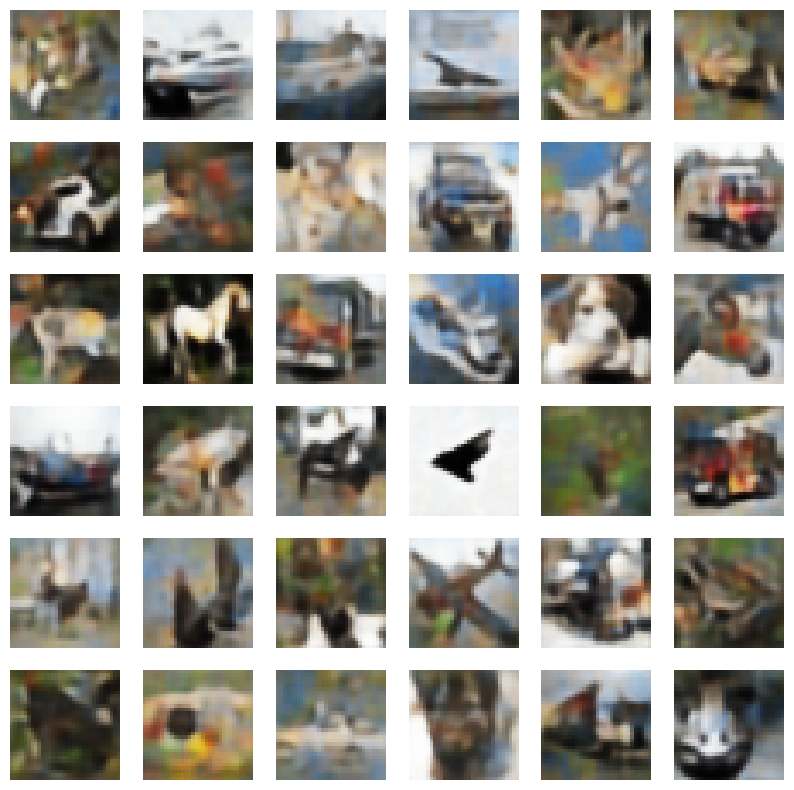

In [25]:
import matplotlib.pyplot as plt

# visualize the colorized images
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
for i in range(6):
    for j in range(6):
        idx = i*6 + j
        axs[i, j].imshow(x_tilde[idx].permute(1, 2, 0))
        axs[i, j].axis('off')
plt.show()


Files already downloaded and verified


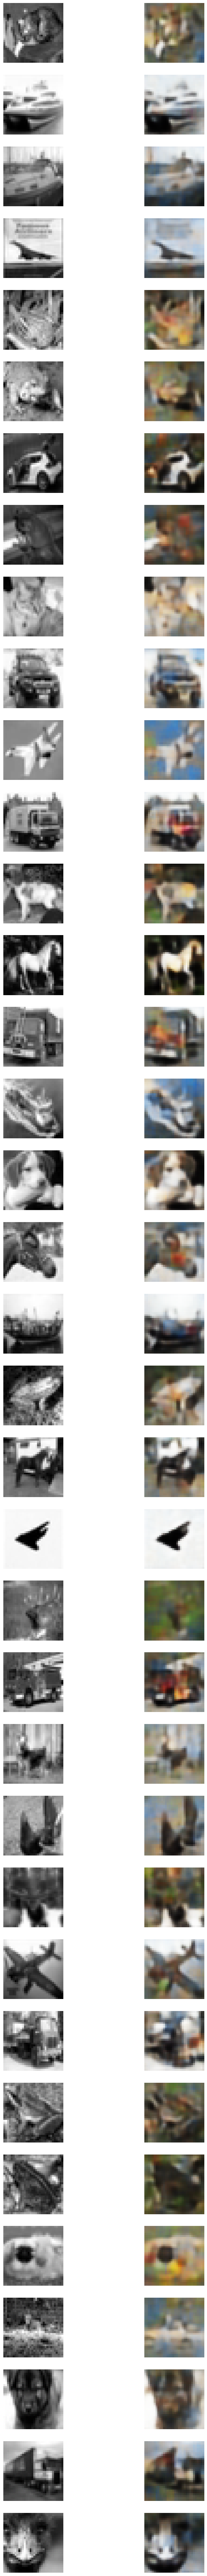

In [26]:
import matplotlib.pyplot as plt

# get 36 images from test dataloader
test_dl = model.test_dataloader()
test_batch = next(iter(test_dl))
x_in, x = test_batch
x_in = x_in[:36]

# pass through the model
with torch.no_grad():
    x_tilde = model(x_in)

# visualize the grayscale and colorized images side by side
fig, axs = plt.subplots(nrows=36, ncols=2, figsize=(10, 100))
for i in range(36):
    axs[i, 0].imshow(x_in[i].squeeze(), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(x_tilde[i].permute(1, 2, 0))
    axs[i, 1].axis('off')
plt.show()
